# DNN text-to-speech synthesis (en)

This notebook demonstrates how to build DNN-based speech synthesis system. We will investigate very simple feed forward neural networks. Steps are composed of:

- Linguistic/Duration/Acoustic feature extraction
- Dataset preparation
- Training duration and acoustic models
- Speech parameter generation and waveform synthesis

Generated audio examples are attached at the bottom of the notebook. For simplicity, feature extraction steps will be performed with an external python script (200 lines). To run the notebook, in addition to nnmnkwii and its dependencies, you will need the following packages:

- pytorch: http://pytorch.org/
- pysptk: https://github.com/r9y9/pysptk
- pyworld: https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder
- librosa: https://github.com/librosa/librosa
- tqdm: https://github.com/tqdm/tqdm
- docopt: https://github.com/docopt/docopt

Please make sure that you have all dependneices if you are trying to run the notebook locally.

```
pip install pysptk pyworld librosa tqdm docopt
```

Part of code was adapted from [Merlin](https://github.com/CSTR-Edinburgh/merlin). Speech analysis/synthesis were done by pysptk and pyworld. Librosa was used to visualize features. PyTorch was used to build DNN models.

The notebooks requires wav files with aligned HTS-style full-context lablel files. You can download the necessary files by the following script.

In [1]:
! ./scripts/download_data.sh slt_arctic_full_data

slt_arctic_full_data already downloaded


In [2]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import FileDataSource, FileSourceDataset
from nnmnkwii.datasets import MemoryCacheFramewiseDataset
from nnmnkwii.util import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.util import minmax, meanvar, minmax_scale, scale
from nnmnkwii import functions as F
from nnmnkwii.io import hts
from nnmnkwii.frontend import merlin as fe
from nnmnkwii.postfilters import merlin_post_filter

from os.path import join, expanduser, basename, splitext, basename, exists
import os
from glob import glob
import numpy as np
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


## Data

In this demo we construct datasets from pre-computed linguistic/duration/acoustic features because computing features from wav/label files on-demand are peformance heavy, particulary for acoustic features. See the following python script if you are interested in how we extract features.

In [3]:
! python ./scripts/prepare_features.py ./data/slt_arctic_full_data

Features for duration model training found, skipping feature extraction.
Features for acousic model training found, skipping feature extraction.


In [4]:
DATA_ROOT = "./data/slt_arctic_full_data"
test_size = 0.112 # This means 1000 utterances for training data
random_state = 1234

### Data specification

Almost same as Merlin's slt_arctic demo. The only difference is that frequency warping paramter `alpha` is set to 0.41, instead of 0.58. As far as I know 0.41 is the best parameter approximating mel-frequency axis for 16kHz-sampled audio signals.

In [5]:
mgc_dim = 180
lf0_dim = 3
vuv_dim = 1
bap_dim = 3

duration_linguistic_dim = 416
acoustic_linguisic_dim = 425
duration_dim = 5
acoustic_dim = mgc_dim + lf0_dim + vuv_dim + bap_dim

fs = 16000
frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

mgc_start_idx = 0
lf0_start_idx = 180
vuv_start_idx = 183
bap_start_idx = 184

windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

### File data sources

We need to specify 1) where to find pre-computed features and 2) how to process them. In this case,

1. `collect_files` : Collects `.bin` files. External python script writes files in binary format. Also we split the files into train/test set.
2. `collect_features` : Just load from file by `np.fromfile`.

In [6]:
class BinaryFileSource(FileDataSource):
    def __init__(self, data_root, dim, train):
        self.data_root = data_root
        self.dim = dim
        self.train = train
    def collect_files(self):
        files = sorted(glob(join(self.data_root, "*.bin")))
        files = files[:len(files)-5] # last 5 is real testset
        train_files, test_files = train_test_split(files, test_size=test_size,
                                                   random_state=random_state)
        if self.train:
            return train_files
        else:
            return test_files
    def collect_features(self, path):
        return np.fromfile(path, dtype=np.float32).reshape(-1, self.dim)

Then we can construct datasets for duraton and acoustic models. We wil have

- X: Input (duration, acoustic) datasets
- Y: Target (duration, acoustic) datasets

Note that dataset itself doesn't keep features in memory. It loads features on-demand while iteration or indexing.

In [7]:
X = {"duration":{}, "acoustic": {}}
Y = {"duration":{}, "acoustic": {}}
utt_lengths = {"duration":{}, "acoustic": {}}
for ty in ["duration", "acoustic"]:
    for phase in ["train", "test"]:
        train = phase == "train"
        x_dim = duration_linguistic_dim if ty == "duration" else acoustic_linguisic_dim
        y_dim = duration_dim if ty == "duration" else acoustic_dim
        X[ty][phase] = FileSourceDataset(BinaryFileSource(join(DATA_ROOT, "X_{}".format(ty)),
                                                       dim=x_dim,
                                                       train=train))
        Y[ty][phase] = FileSourceDataset(BinaryFileSource(join(DATA_ROOT, "Y_{}".format(ty)),
                                                       dim=y_dim,
                                                       train=train))
        # this triggers file loads, but can be neglectable in terms of performance.
        utt_lengths[ty][phase] = [len(x) for x in X[ty][phase]]

### Utterance lengths

Let's see utterance lengths histrogram.

Total number of utterances: 1000
Total number of frames: 32006


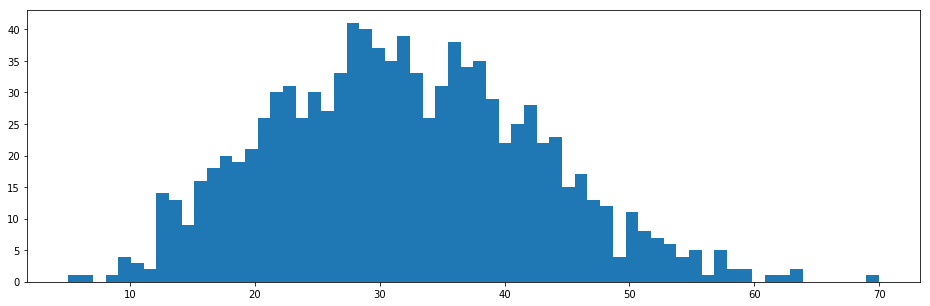

In [8]:
print("Total number of utterances:", len(utt_lengths["duration"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["duration"]["train"]))
hist(utt_lengths["duration"]["train"], bins=64);

Total number of utterances: 1000
Total number of frames: 534363


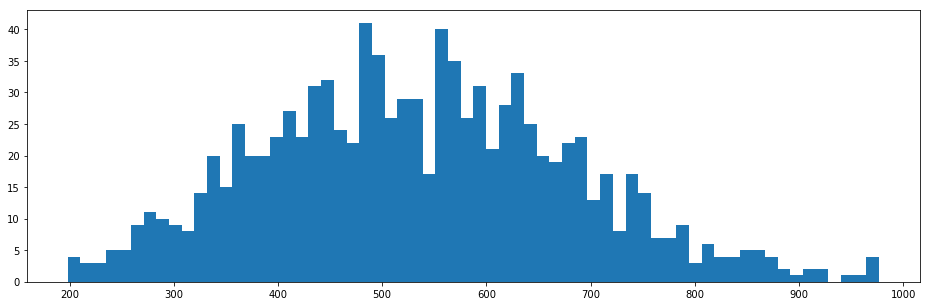

In [9]:
print("Total number of utterances:", len(utt_lengths["acoustic"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["acoustic"]["train"]))
hist(utt_lengths["acoustic"]["train"], bins=64);

### How data look like?

Pick an utterance from training data and visualize its features.

In [10]:
def vis_utterance(X, Y, lengths, idx):
    """Visualize the following features:
    
    1. Linguistic features
    2. Spectrogram
    3. Log-F0
    4. Aperiodicity
    """
    x = X[idx][:lengths[idx]]
    y = Y[idx][:lengths[idx]]
    
    figure(figsize=(16,20))
    subplot(4,1,1)
    # haha, better than text?
    librosa.display.specshow(x.T, sr=fs, hop_length=hop_length, x_axis="time")
    
    subplot(4,1,2)
    logsp = np.log(pysptk.mc2sp(y[:,mgc_start_idx:mgc_dim//len(windows)], alpha=alpha, fftlen=fftlen))
    librosa.display.specshow(logsp.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    
    subplot(4,1,3)
    lf0 = y[:,mgc_start_idx]
    vuv = y[:,vuv_start_idx]
    plot(lf0, linewidth=2, label="Continuous log-f0")
    plot(vuv, linewidth=2, label="Voiced/unvoiced flag")
    legend(prop={"size": 14}, loc="upper right")
    
    subplot(4,1,4)
    bap = y[:,bap_start_idx:bap_start_idx+bap_dim//len(windows)]
    bap = np.ascontiguousarray(bap).astype(np.float64)
    aperiodicity = pyworld.decode_aperiodicity(bap, fs, fftlen)
    librosa.display.specshow(aperiodicity.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")

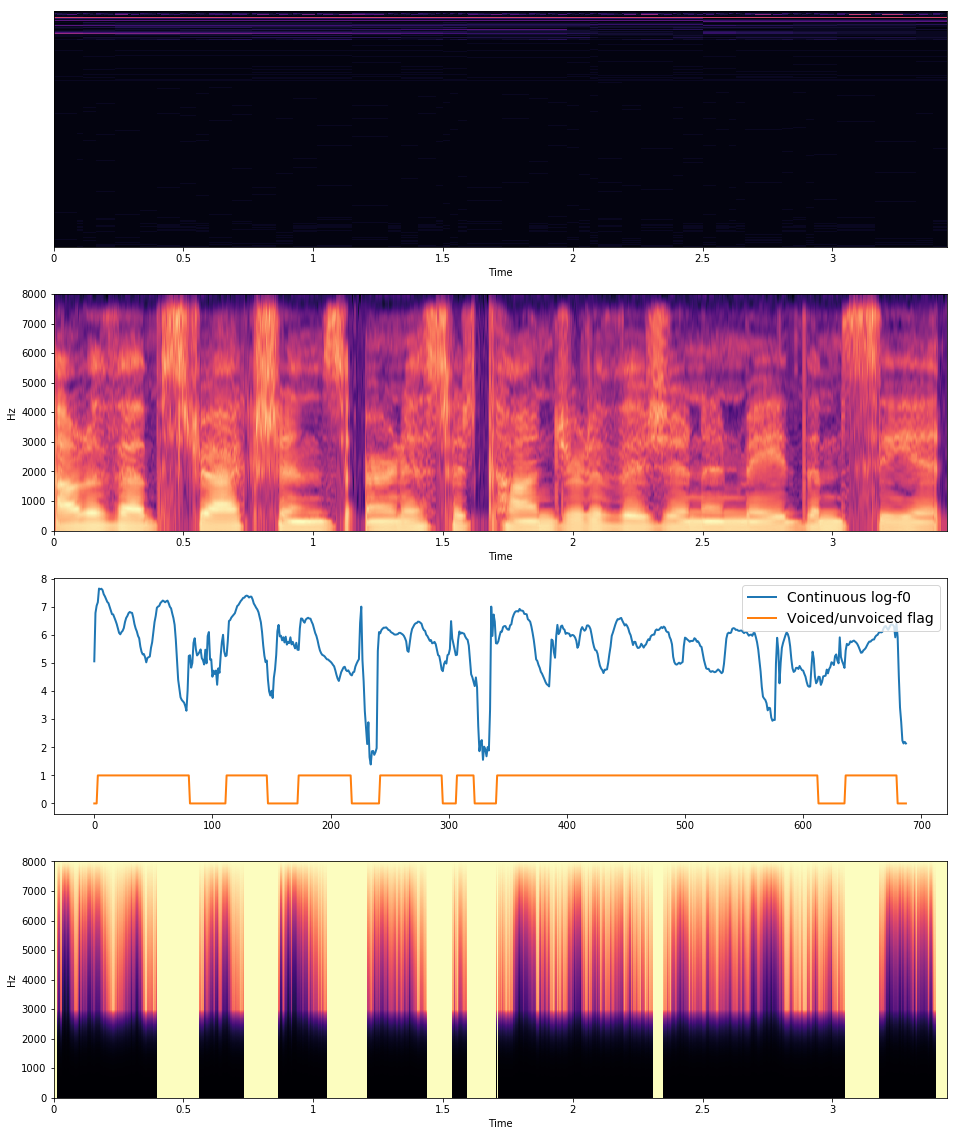

In [11]:
idx = 0 # any
vis_utterance(X["acoustic"]["train"], Y["acoustic"]["train"], utt_lengths["acoustic"]["train"], idx)

As you can see the top of the images, linguistic features are not clear. This is because linguistic features have very differnt scale for each dimention. This will be clear after normalization.

### Statistics

Before training neural networks, we need to normalize data. Following Merlin's demo script, we will apply min/max normalization for linguistic features and mean/variance normalization to duration/acoustic features. You can compute necessary statistics using `nnmnkwii.util.minmax` and `nnmnkwii.util.meanvar`. The comptuation is online, so we can use the functionality for any large dataset.

In [12]:
X_min = {}
X_max = {}
Y_mean = {}
Y_var = {}
Y_scale = {}

for typ in ["acoustic", "duration"]:
    X_min[typ], X_max[typ] = minmax(X[typ]["train"], utt_lengths[typ]["train"])
    Y_mean[typ], Y_var[typ] = meanvar(Y[typ]["train"], utt_lengths[typ]["train"])
    Y_scale[typ] = np.sqrt(Y_var[typ])

Linguistic features should be clear with normalization as follows.

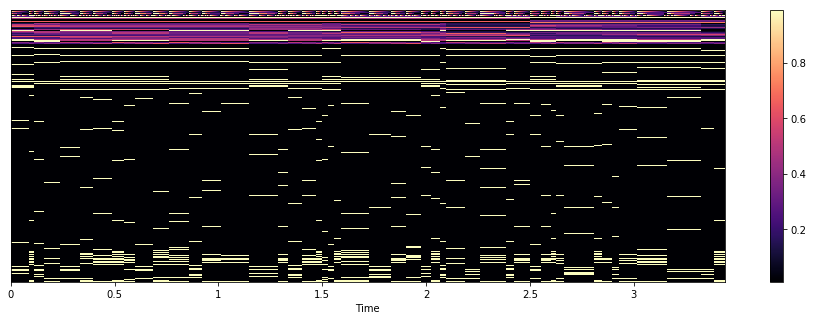

In [13]:
idx = 0
typ = "acoustic"
x = X[typ]["train"][idx][:utt_lengths[typ]["train"][idx]]
x = minmax_scale(x, X_min[typ], X_max[typ], feature_range=(0.01, 0.99))
librosa.display.specshow(x.T, sr=fs, hop_length=hop_length, x_axis="time")
colorbar()

### Combine datasets and normalization.

In this demo we use PyTorch to build DNNs. `PyTorchDataset` is just a glue Dataset wrapper, which combines our dataset and normalization.

In [14]:
from torch.utils import data as data_utils
import torch

class PyTorchDataset(torch.utils.data.Dataset):
    """Thin dataset wrapper for pytorch
    
    This does just two things:
        1. On-demand normalization
        2. Returns torch.FlaotTensor instead of numpy.ndarray
    """
    def __init__(self, X, Y, X_min, X_max, Y_mean, Y_scale):
        self.X, self.Y = X, Y
        self.X_min, self.X_max = X_min, X_max
        self.Y_mean, self.Y_scale = Y_mean, Y_scale
    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        x = minmax_scale(x, self.X_min, self.X_max, feature_range=(0.01, 0.99))
        y = scale(y, self.Y_mean, self.Y_scale)
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        return x, y
    def __len__(self):
        return len(self.X)

##  Model

We use pretty simple deep feed forward neural networks.

In [15]:
import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tnrange, tqdm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

### Model definition

In [16]:
class MyNet(torch.nn.Module):
    """Very simple deep neural networks.
    """
    def __init__(self, D_in, H, D_out, num_layers=2):
        super(MyNet, self).__init__()
        self.first_linear = nn.Linear(D_in, H)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(H, H) for _ in range(num_layers)])
        self.last_linear = nn.Linear(H, D_out)
        self.relu = nn.Tanh()

    def forward(self, x):
        h = self.relu(self.first_linear(x))
        for hl in self.hidden_layers:
            h = self.relu(hl(h))
        return self.last_linear(h)

## Train

### Configurations

Network hyper parameters and training configurations (learning rate, weight decay, etc).

In [17]:
num_hidden_layers = 3
hidden_size = 256
batch_size = 256
# We use PyTorch's multiprocess iterator. Note that large n_workers causes
# dataset copies across proccess.
n_workers = 4
pin_memory = True
nepoch = 25
lr = 0.001
weight_decay = 1e-6
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### Training loop

Our network predicts output features frame-by-frame, so we need to convert our datasets to support frame-wise iteration. `MemoryCacheFramewiseDataset` can do this with cache functionality. The training loop is pretty simple.

In [18]:
def train(model, optimizer, X, Y, X_min, X_max, Y_mean, Y_scale,
          utt_lengths, cache_size=1000):
    if use_cuda:
        model = model.cuda()
        
    X_train, X_test = X["train"], X["test"]
    Y_train, Y_test = Y["train"], Y["test"]
    train_lengths, test_lengths = utt_lengths["train"], utt_lengths["test"]
        
    # Frame-wise train data loader
    X_train_cache_dataset = MemoryCacheFramewiseDataset(
        X_train, train_lengths, cache_size)
    Y_train_cache_dataset = MemoryCacheFramewiseDataset(
        Y_train, train_lengths, cache_size)
    train_dataset = PyTorchDataset(X_train_cache_dataset, Y_train_cache_dataset,
                                  X_min, X_max, Y_mean, Y_scale)
    train_loader = data_utils.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=n_workers, 
        pin_memory=pin_memory, shuffle=True)
    print("Train dataset number of frames", len(train_dataset))
    
    # Frame-wise test data loader
    X_test_cache_dataset = MemoryCacheFramewiseDataset(
        X_test, test_lengths, cache_size)
    Y_test_cache_dataset = MemoryCacheFramewiseDataset(
        Y_test, test_lengths, cache_size)
    test_dataset = PyTorchDataset(X_test_cache_dataset, Y_test_cache_dataset,
                                 X_min, X_max, Y_mean, Y_scale)
    test_loader = data_utils.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=n_workers,
        pin_memory=pin_memory, shuffle=False)
    print("Test dataset numer of frames", len(test_dataset))
    
    dataset_loaders = {"train": train_loader, "test": test_loader}
    
    # Training loop
    criterion = nn.MSELoss()
    model.train()
    print("Start frame-wise training...")
    loss_history = {"train": [], "test": []}
    for epoch in tnrange(nepoch):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for x, y in dataset_loaders[phase]:
                if use_cuda:
                    x, y = x.cuda(), y.cuda()
                x, y = Variable(x), Variable(y)
                optimizer.zero_grad()
                y_hat = model(x)
                loss = criterion(y_hat, y)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0]
            loss_history[phase].append(running_loss / len(dataset_loaders[phase]))
        
    return loss_history

### Define models

In [19]:
models = {}
for typ in ["duration", "acoustic"]:
    models[typ] = MyNet(X[typ]["train"][0].shape[-1],
                            hidden_size, Y[typ]["train"][0].shape[-1],
                            num_hidden_layers)
    print("Model for {}\n".format(typ), models[typ])

Model for duration
 MyNet (
  (first_linear): Linear (416 -> 256)
  (hidden_layers): ModuleList (
    (0): Linear (256 -> 256)
    (1): Linear (256 -> 256)
    (2): Linear (256 -> 256)
  )
  (last_linear): Linear (256 -> 5)
  (relu): Tanh ()
)
Model for acoustic
 MyNet (
  (first_linear): Linear (425 -> 256)
  (hidden_layers): ModuleList (
    (0): Linear (256 -> 256)
    (1): Linear (256 -> 256)
    (2): Linear (256 -> 256)
  )
  (last_linear): Linear (256 -> 187)
  (relu): Tanh ()
)


### Training Duration model

In [20]:
ty = "duration"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Train dataset number of frames 32006
Test dataset numer of frames 4122
Start frame-wise training...


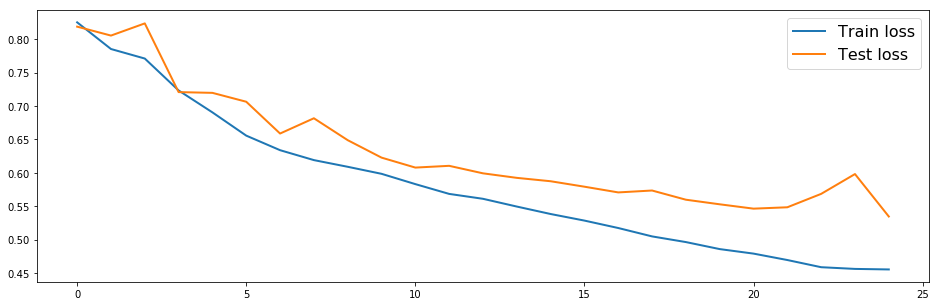

In [21]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})

### Training acoustic model

In [22]:
ty = "acoustic"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Train dataset number of frames 534363
Test dataset numer of frames 69249
Start frame-wise training...


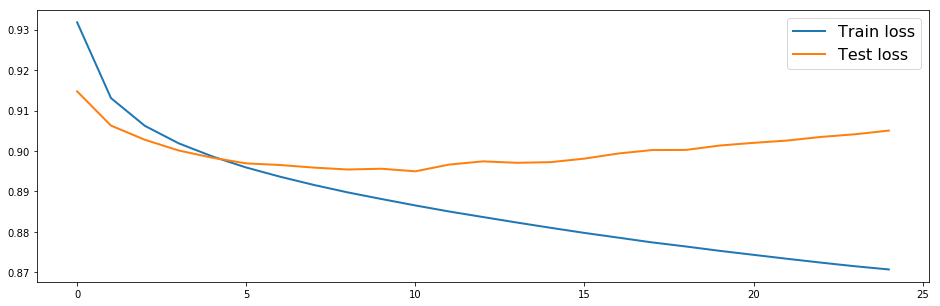

In [23]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})

## Test

Let's see how our network works.

### Parameter generation utilities

Not going to explain in details, but I think it's fairly simple and easy to understand. One thing I should note that is we are using `nnmnkwii.postfilters.merlin_post_filter`, which does same thing in Merlin's default post filter.

In [26]:
binary_dict, continuous_dict = hts.load_question_set(
    join(DATA_ROOT, "questions-radio_dnn_416.hed"))

def gen_parameters(y_predicted):
    # Number of time frames
    T = y_predicted.shape[0]
    
    # Split acoustic features
    mgc = y_predicted[:,:lf0_start_idx]
    lf0 = y_predicted[:,lf0_start_idx:vuv_start_idx]
    vuv = y_predicted[:,vuv_start_idx]
    bap = y_predicted[:,bap_start_idx:]
    
    # Perform MLPG
    ty = "acoustic"
    mgc_variances = np.tile(Y_var[ty][:lf0_start_idx], (T, 1))
    mgc = F.mlpg(mgc, mgc_variances, windows)
    lf0_variances = np.tile(Y_var[ty][lf0_start_idx:vuv_start_idx], (T,1))
    lf0 = F.mlpg(lf0, lf0_variances, windows)
    bap_variances = np.tile(Y_var[ty][bap_start_idx:], (T, 1))
    bap = F.mlpg(bap, bap_variances, windows)
    
    return mgc, lf0, vuv, bap

def gen_waveform(y_predicted, do_postfilter=False):  
    y_predicted = trim_zeros_frames(y_predicted)
        
    # Generate parameters and split streams
    mgc, lf0, vuv, bap = gen_parameters(y_predicted)
    
    if do_postfilter:
        mgc = merlin_post_filter(mgc, alpha)
        
    spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
    aperiodicity = pyworld.decode_aperiodicity(bap, fs, fftlen)
    f0 = lf0.copy()
    f0[vuv < 0.5] = 0
    f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])
    
    generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                            spectrogram.astype(np.float64),
                                            aperiodicity.astype(np.float64),
                                            fs, frame_period)
    return generated_waveform
    
def gen_duration(label_path, duration_model):
    # Linguistic features for duration
    hts_labels = hts.load(label_path)
    duration_linguistic_features = fe.linguistic_features(hts_labels,
                                               binary_dict, continuous_dict,
                                               add_frame_features=False,
                                               subphone_features=None).astype(np.float32)

    # Apply normalization
    ty = "duration"
    duration_linguistic_features = minmax_scale(
        duration_linguistic_features, X_min[ty], X_max[ty], feature_range=(0.01, 0.99))
    
    # Apply model
    duration_model = duration_model.cpu()
    duration_model.eval()
    x = Variable(torch.from_numpy(duration_linguistic_features)).float()
    duration_predicted = duration_model(x).data.numpy()
        
    # Apply denormalization
    duration_predicted = duration_predicted * Y_scale[ty] + Y_mean[ty]
    duration_predicted = np.round(duration_predicted)
    
    # Set minimum state duration to 1
    duration_predicted[duration_predicted <= 0] = 1
    hts_labels.set_durations(duration_predicted)
    
    return hts_labels    


def test_one_utt(label_path, duration_model, acoustic_model, post_filter=True):
    # Predict durations
    duration_modified_hts_labels = gen_duration(label_path, duration_model)
    
    # Linguistic features
    linguistic_features = fe.linguistic_features(duration_modified_hts_labels, 
                                                  binary_dict, continuous_dict,
                                                  add_frame_features=True,
                                                  subphone_features="full")
    # Trim silences
    indices = duration_modified_hts_labels.silence_frame_indices()
    linguistic_features = np.delete(linguistic_features, indices, axis=0)

    # Apply normalization
    ty = "acoustic"
    linguistic_features = minmax_scale(linguistic_features, 
                                       X_min[ty], X_max[ty], feature_range=(0.01, 0.99))
    
    # Predict acoustic features
    acoustic_model = acoustic_model.cpu()
    acoustic_model.eval()    
    x = Variable(torch.from_numpy(linguistic_features)).float()
    acoustic_predicted = acoustic_model(x).data.numpy()
             
    # Apply denormalization
    acoustic_predicted = acoustic_predicted * Y_scale[ty] + Y_mean[ty]
    
    return gen_waveform(acoustic_predicted, post_filter)    

### Listen generated audio

Generated audio with Merlin's slt_full_demo is also attached. You can compare them below.

In [25]:
test_label_paths = sorted(glob(join(DATA_ROOT, "label_state_align/", "*.lab")))[::-1][:5][::-1]
merlin_generated_wav_files = sorted(glob(join("./generated/merlin_slt_arctic_full/*.wav")))

# Save generated wav files for later comparizon
save_dir = join("./generated/01-tts")
if not exists(save_dir):
    os.makedirs(save_dir)

for label_path, wav_path in zip(test_label_paths, merlin_generated_wav_files):
    print("MyNet")
    waveform = test_one_utt(label_path, models["duration"], models["acoustic"])
    wavfile.write(join(save_dir, basename(wav_path)), rate=fs, data=waveform)
    IPython.display.display(Audio(waveform, rate=fs))
    
    print("Merlin (slt_arctic_full, generated with default configurations)")
    fs, waveform = wavfile.read(wav_path)
    IPython.display.display(Audio(waveform, rate=fs))    

MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)


MyNet


Merlin (slt_arctic_full, generated with default configurations)
